In [4]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import copy
import sys
from sklearn.model_selection import train_test_split
import os

file_path = os.path.dirname(os.getcwd())

def load_data(file_path=file_path+'/u.data'):
    prefer = []
    for line in open(file_path, 'r'):
        (userid, movieid, rating, ts) = line.split('\t')
        uid = int(userid)
        mid = int(movieid)
        rat = float(rating)
        prefer.append([uid, mid, rat])
    data = np.array(prefer)
    return data

ratings = load_data()
df = pd.DataFrame(ratings, columns=['user', 'item', 'rating'])

In [6]:
# Train Test Split for each user
data = df
user_set = data.groupby('user').groups.values()

# 각 user 그룹의 데이터를 80:20 비율로 분할하여 train과 test indices 구성
train_indices = []
test_indices = []
for i, indices in enumerate(user_set):
    train_group_indices, test_group_indices = train_test_split(indices, test_size=0.2, random_state=42)
    train_indices.extend(train_group_indices)
    test_indices.extend(test_group_indices)

# train_df와 test_df 생성
train_df = data.loc[train_indices]
test_df = data.loc[test_indices]

print("Train DataFrame:")
print(train_df.shape)
print("Test DataFrame:")
print(test_df.shape)

Train DataFrame:
(79619, 3)
Test DataFrame:
(20381, 3)


In [36]:
# parameters
lambda_ = 150
alpha_ = 40
epsilon_ = 10**(-8)
n_factor = 100

# R matrix
def create_R_matrix(df, train_set):
    # 모든 고유한 user와 item을 추출
    all_users = np.unique((df['user'].unique()))
    all_items = np.unique((df['item'].unique()))

    # 행렬 초기화
    ratings_matrix = pd.DataFrame(0, index=all_users, columns=all_items)

    # train set에 있는 데이터로 행렬 채우기
    for _, row in train_set.iterrows():
        user = row['user']
        item = row['item']
        ratings = row['rating']
        ratings_matrix.loc[user, item] = ratings

    return np.array(ratings_matrix)

# P matrix
def create_P_matrix(R_matrix):
    P_matrix = copy.deepcopy(R_matrix)
    P_matrix[R_matrix>0] = 1
    return P_matrix

# C matrix
def create_C_matrix(R_matrix):
    C_matrix = 1 + alpha_*np.log(1+R_matrix/epsilon_)
    C_matrix = np.array(C_matrix)
    return C_matrix

In [37]:
R_matrix = create_R_matrix(data, train_df)
C_matrix = create_C_matrix(R_matrix)
P_matrix = create_P_matrix(R_matrix)

m = R_matrix.shape[0]
n = R_matrix.shape[1]

In [40]:
R_matrix

array([[5, 0, 4, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [5, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 5, 0, ..., 0, 0, 0]], dtype=int64)

In [42]:
C_matrix

array([[802.20474634,   1.        , 793.2790043 , ...,   1.        ,
          1.        ,   1.        ],
       [  1.        ,   1.        ,   1.        , ...,   1.        ,
          1.        ,   1.        ],
       [  1.        ,   1.        ,   1.        , ...,   1.        ,
          1.        ,   1.        ],
       ...,
       [802.20474634,   1.        ,   1.        , ...,   1.        ,
          1.        ,   1.        ],
       [  1.        ,   1.        ,   1.        , ...,   1.        ,
          1.        ,   1.        ],
       [  1.        , 802.20474634,   1.        , ...,   1.        ,
          1.        ,   1.        ]])

In [41]:
P_matrix

array([[1, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 1, 0, ..., 0, 0, 0]], dtype=int64)

In [45]:
class OCCF():
    def __init__(self, R, C, P, m, n, n_itr=10, num_factor=10, lamdba_=150):
        self.R = R
        self.C = C
        self.P = P
        self.m = m
        self.n = n
        self.n_itr = n_itr
        self.num_factor = num_factor
        self.X = np.random.rand(m, num_factor) * 0.01
        self.Y = np.random.rand(n, num_factor) * 0.01
        self.lambda_ = lamdba_


    def loss_function(self, pred):
        predict_error = np.square(self.P-pred)
        confidence_error = np.sum(self.C*predict_error)
        regularization_error = lambda_*(np.sum(np.square(self.X))+np.sum(np.square(self.Y)))
        total_loss = confidence_error + regularization_error
        return np.sum(predict_error), confidence_error, regularization_error, total_loss
    
    def user_optimization(self):
        yT = np.transpose(self.Y)
        yTy = np.matmul(yT, self.Y)
        for user in range(self.m):
            Cu = np.diag(self.C[user])
            yT_Cu_y = yTy + np.matmul(np.matmul(yT, Cu - np.identity(self.n)),self.Y)
            lambda_I = lambda_ * np.identity(self.num_factor)
            yT_Cu_pu = np.matmul(np.matmul(yT,Cu), np.transpose(self.P[user]))
            self.X[user] = np.linalg.solve(yT_Cu_y+lambda_I, yT_Cu_pu)
            
    def item_optimization(self):
        xT = np.transpose(self.X)
        xTx = np.matmul(xT, self.X)
        for item in range(self.n):
            Ci = np.diag(self.C[:,item])
            xT_Ci_x = xTx + np.matmul(np.matmul(xT, Ci - np.identity(self.m)),self.X)
            lambda_I = lambda_ * np.identity(self.num_factor)
            xT_Ci_pi = np.matmul(np.matmul(xT,Ci), np.transpose(self.P[:,item]))
            self.Y[item] = np.linalg.solve(xT_Ci_x+lambda_I, xT_Ci_pi)
            
    def fit(self):
        predict_errors = []
        confidence_errors = []
        regularization_list = []
        total_losses = []

        for i in range(self.n_itr):
            print(f'processing on {i+1}th iteration')
            if i != 0:
                self.user_optimization()
                self.item_optimization()

            predict = np.matmul(self.X, np.transpose(self.Y))

            predict_error, confidence_error, regularization, total_loss = self.loss_function(predict)

            predict_errors.append(predict_error)
            confidence_errors.append(confidence_error)
            regularization_list.append(regularization)
            total_losses.append(total_loss)

            print(f'{i+1}th iteration is done')

        fin_predict = np.matmul(self.X, np.transpose(self.Y))
        print('final predict')
        print([fin_predict])
        return fin_predict, predict_errors, confidence_errors, regularization_list, total_losses

In [46]:
OCCF = OCCF(R_matrix, C_matrix, P_matrix, m, n)
_,_,_,_,total_losses = OCCF.fit()


processing on 1th iteration
1th iteration is done
processing on 2th iteration
2th iteration is done
processing on 3th iteration
3th iteration is done
processing on 4th iteration
4th iteration is done
processing on 5th iteration
5th iteration is done
processing on 6th iteration
6th iteration is done
processing on 7th iteration
7th iteration is done
processing on 8th iteration
8th iteration is done
processing on 9th iteration
9th iteration is done
processing on 10th iteration
10th iteration is done
final predict
[array([[ 1.00712214,  1.00743429,  0.92812882, ...,  0.        ,
         0.76972593,  0.27071647],
       [ 1.00034376,  0.13437041,  0.80864991, ...,  0.        ,
         0.11073834,  0.1076139 ],
       [ 0.76241958,  0.51810019,  0.49758783, ...,  0.        ,
         0.20394076,  0.09170298],
       ...,
       [ 0.99239825,  0.30625759,  0.68970324, ...,  0.        ,
        -0.08381644, -0.08681954],
       [ 0.90869958,  0.95133056,  0.60431218, ...,  0.        ,
      

In [70]:
import numpy as np

def calculate_epr(pred, user_item_matrix):

    num_users, num_items = user_item_matrix.shape
    percentile_rankings = []

    for user in range(num_users):
        # Get model predictions for this user
        predictions = pred
        # Identify interacted and non-interacted items
        interacted_items = np.where(user_item_matrix[user] == 1)[0]
        non_interacted_items = np.where(user_item_matrix[user] == 0)[0]

        # Calculate percentile ranking for each interacted item
        for item in interacted_items:
            # Count how many non-interacted items are ranked lower
            # In other words, for a good model, we expect interacted (positive) items to have higher scores than non-interacted ones.
            # prediction user x item matrix 가 잘 예측 했는지 평가하려면 기존 user x item 에서의 positive item 이 prediction score에서 더 높은 점수를 가지고 있어야함
            num_lower = np.sum(predictions[user][non_interacted_items] < predictions[user][item])
            # 하지만 ranking이 낮을수록 more recommended 이기 때문에
            percentile_ranking = 1 - num_lower / len(non_interacted_items)
            percentile_rankings.append(percentile_ranking)

    # Average the percentile rankings
    average_epr = np.mean(percentile_rankings)
    return average_epr


In [59]:
test_user_item_matrix = create_R_matrix(data, test_df)
test_user_item_matrix[test_user_item_matrix>0] = 1
test_user_item_matrix

array([[0, 1, 0, ..., 0, 0, 0],
       [1, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int64)

In [72]:
pred = np.matmul(OCCF.X, np.transpose(OCCF.Y))
pred

array([[ 1.00712214,  1.00743429,  0.92812882, ...,  0.        ,
         0.76972593,  0.27071647],
       [ 1.00034376,  0.13437041,  0.80864991, ...,  0.        ,
         0.11073834,  0.1076139 ],
       [ 0.76241958,  0.51810019,  0.49758783, ...,  0.        ,
         0.20394076,  0.09170298],
       ...,
       [ 0.99239825,  0.30625759,  0.68970324, ...,  0.        ,
        -0.08381644, -0.08681954],
       [ 0.90869958,  0.95133056,  0.60431218, ...,  0.        ,
        -0.00103704,  0.1538752 ],
       [ 1.00578551,  1.00378727,  0.97315148, ...,  0.        ,
         0.32822093,  0.11298142]])

In [71]:
calculate_epr(pred, test_user_item_matrix)

0.17043531630261569

In [73]:
user_index = 0
top_k = 5
scores = pred[user_index]
top_items_indices = np.argsort(scores)[::-1][:top_k]

top_items_indices

array([ 889, 1482,  354,  348,  308], dtype=int64)

In [85]:
pred[0][([889, 1482,  354,  348,  308])]

array([1.33692207, 1.22818467, 1.22174479, 1.21632307, 1.21595238])

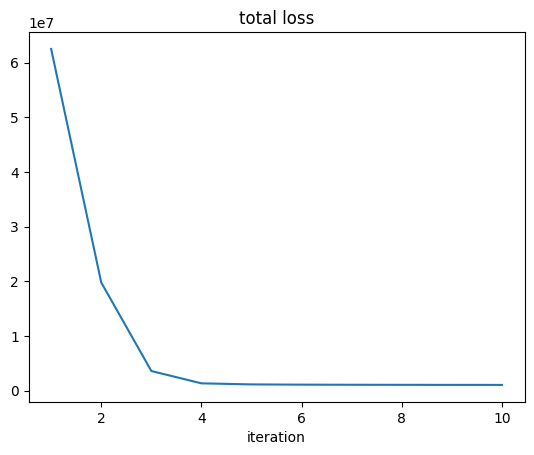

In [48]:
# total_losses
x_axis = np.arange(1,11)
y_axis = total_losses
plt.plot(x_axis, y_axis)
plt.xlabel("iteration")
plt.title("total loss")
plt.show()